
# EEG Alpha Power Analysis Pipeline

This script processes EEG data to compare alpha power (log-transformed mean amplitude) across two conditions ("left" and "right" trials). 

---

## **1. Data Preprocessing**
- Loads preprocessed EEG data for each subject.
- Selects relevant channels, applies a bandpass filter (8-12 Hz), and removes edge    artifacts.
- Computes log-transformed Hilbert amplitude to quantify alpha power.

## **2. Channel Selection**
- Automatically excludes noisy channels for specific subjects based on a rejection list.
- Focuses on specific channels of interest (e.g., `O1`, `O2`, `P3`, `P4`, `P7`, `P8`, `Oz`).

## **3. Condition Segmentation**
- Separates trials into "left" and "right" conditions based on trial labels.
- Stores processed features and labels for further analysis.

## **4. Data preparation**
- Calculates mean and standard error for alpha power across subjects and conditions.

## **5. Visualization**
- Generates and saves two plots:
  - **Grouped Bar Plot:** Alpha power by condition and channel.
  - **Difference Plot:** Condition difference (`right - left`) with error bars.
```

In [1]:
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, hilbert

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")

In [2]:
subjects = [
    "VPpdia", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", 
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", 
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
]

picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]
task = "covert"

subjects_channel_reject = {
    "VPpdib": ["CP2"],
    "VPpdih": ["C3"],
    "VPpdizb": ["Fz"],
    "VPpdizc": ["FC2"]
}

def compute_average_hilbert_amplitude(data):
    
    analytic = hilbert(data, axis=-1)
    amplitude = np.abs(analytic)
    mean_amplitude = np.mean(amplitude, axis=-1)
    log_mean = np.log(mean_amplitude)
    return log_mean

def bandpass_filter(data, lowcut, highcut, fs = 120, order=4):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)


In [3]:

# Initialize lists to collect features and labels from all subjects

all_subject_features = []
all_subject_labels = []

for subj_id, subject in enumerate(subjects):
    
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha.npz")

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    picks_clean = picks_hubner.copy()
    #Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)
   
    npz_data = np.load(file_path)
    X = npz_data['X']  # (n_trials, n_channels, n_samples)
    y = npz_data['y']  # (n_trials,)

    # When updating the channels to be plotted, also adjust the order array 'new_order' in 109
    selected_channels = ['O1', 'O2' , 'P3', 'P4', 'P7', 'P8', 'Oz',  'F3', 'F4']
    selected_indices = [picks_clean.index(ch) for ch in selected_channels if ch in picks_clean]

    # Subselect channels
    data = X[:, selected_indices, :]

    # Apply bandpass filter to the selected data
    data = bandpass_filter(data, 8, 12)  # alpha band

    # Crop edge artifacts (example: remove 120 samples from start and end)
    data = data[:, :, 120:-120]

    # Compute the log-mean amplitude per trial and channel
    log_mean = compute_average_hilbert_amplitude(data)  # shape: (n_trials, n_channels)

    # Append to the global lists
    all_subject_features.append(log_mean)  # shape: (n_trials, n_channels, 1)
    all_subject_labels.append(y)           # (n_trials,)
feature_array = np.array(all_subject_features)  # shape: (n_subjects, n_trials, n_channels, 1)
label_array = np.array(all_subject_labels) 

left_trials = []
right_trials = []
for s in range(feature_array.shape[0]):
    subj_features = all_subject_features[s]  # (n_trials, n_channels, 1)
    subj_labels = label_array[s]      # (n_trials,)

    left_mask = (subj_labels == 0)
    right_mask = (subj_labels == 1)

    # Select only the left trials
    subj_left = subj_features[left_mask]   # shape: (n_trials/2, n_channels, 1)
    subj_right = subj_features[right_mask] # shape: (n_trials/2, n_channels, 1)
    left_trials.append(subj_left)
    right_trials.append(subj_right)

# Convert to arrays
left_trials = np.array(left_trials)   # shape: (n_subjects, n_trials/2, n_channels, 1)
right_trials = np.array(right_trials)

[]

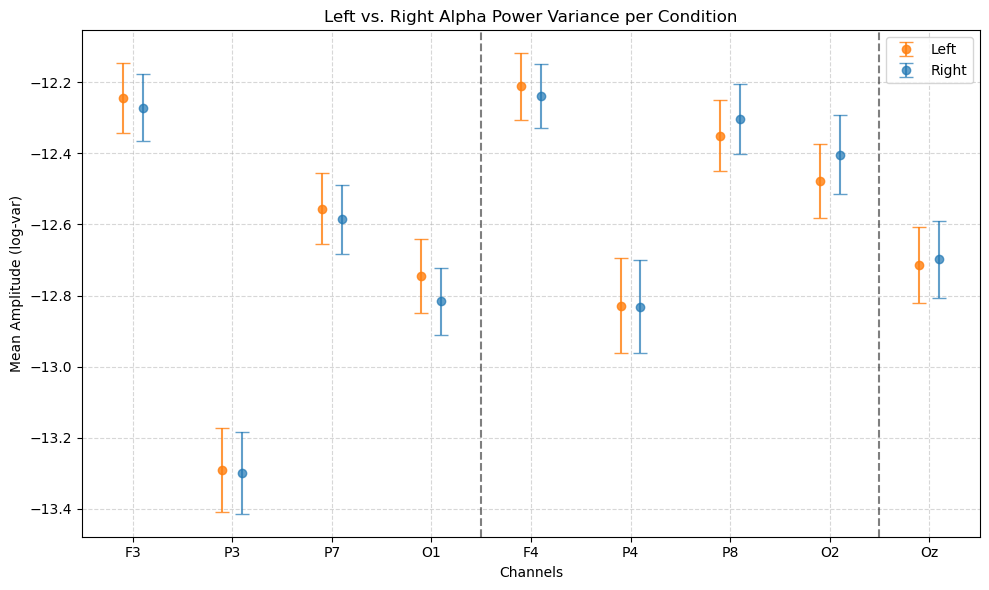

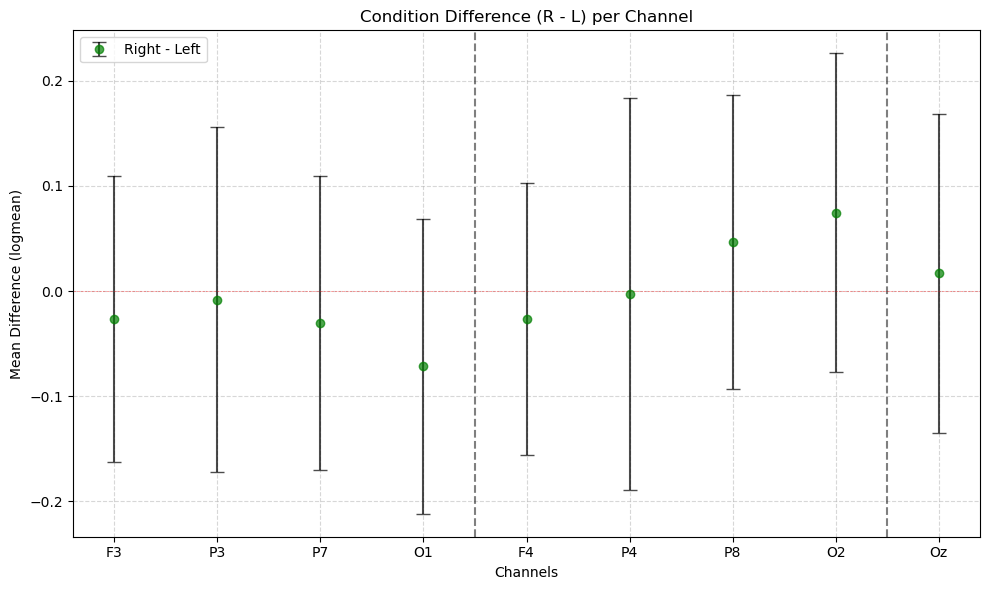

In [ ]:
## Visualize
original_order = selected_channels
# The new desired order
new_order = ['F3','P3', 'P7', 'O1', 'F4', 'P4', 'P8', 'O2', 'Oz']
# Create an index map from original_order to new_order
idx = [original_order.index(ch) for ch in new_order]

# Average across trials (axis=1), resulting in shape (n_subj, n_channels, 1)
left_subj_avg = left_trials.mean(axis=1)   
right_subj_avg = right_trials.mean(axis=1) 

# Compute mean across subjects (axis=0)
left_mean = left_subj_avg.mean(axis=0)   
right_mean = right_subj_avg.mean(axis=0) 

# Compute standard deviation across subjects for SE
# shape is (n_channels, 1)
left_std = left_subj_avg.std(axis=0)
right_std = right_subj_avg.std(axis=0)

n_subjects = left_subj_avg.shape[0]  # n_subj
left_se = left_std / np.sqrt(n_subjects)  # (n_channels, 1)
right_se = right_std / np.sqrt(n_subjects) # (n_channels, 1)

# Reorder the arrays according to new_order
left_mean_reordered = left_mean[idx]
right_mean_reordered = right_mean[idx]
left_se_reordered = left_se[idx]
right_se_reordered = right_se[idx]

# Create a grouped bar plot
x = np.arange(len(new_order)) 

fig, ax = plt.subplots(figsize=(10, 6))

# Plot left scatter points with error bars
ax.errorbar(x - 0.1, left_mean_reordered, yerr=abs(left_se_reordered), 
            fmt='o', capsize=5, label='Left', alpha=0.8, color='tab:orange')

# Plot right scatter points with error bars
ax.errorbar(x + 0.1, right_mean_reordered, yerr=abs(right_se_reordered), 
            fmt='o', capsize=5, label='Right', alpha=0.7, color='tab:blue')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(new_order)

ax.set_title('Left vs. Right Alpha Power Variance per Condition')
ax.set_xlabel('Channels')
ax.set_ylabel('Mean Amplitude (log-var)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Lines to seperate ROI
ax.axvline(x=7.5, color='k', linestyle='--', alpha = 0.5)
ax.axvline(x=3.5, color='k', linestyle='--', alpha = 0.5)

plt.tight_layout()

# Save
plots_dir = join(alpha_dir, "plots")
os.makedirs(os.path.dirname(plots_dir), exist_ok=True)
save_dir = join(plots_dir, f"RvsL_enevlope_amplitude.png")
plt.savefig(save_dir, dpi=300)
plt.plot()

# ------------------------------------------------------------------------------------
# Visualize difference Plots
difference = right_mean_reordered - left_mean_reordered
difference_se = np.sqrt((left_se_reordered**2) + (right_se_reordered**2))
fig, ax = plt.subplots(figsize=(10, 6))

# Plot differences with error bars
ax.errorbar(x, difference, yerr=difference_se, fmt='o', capsize=5, color='green', 
            ecolor='black', label='Right - Left', alpha=0.7)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(new_order)

ax.set_title('Condition Difference (R - L) per Channel')
ax.set_xlabel('Channels')
ax.set_ylabel('Mean Difference (logmean)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.axvline(x=7.5, color='k', linestyle='--', alpha = 0.5)
ax.axvline(x=3.5, color='k', linestyle='--', alpha = 0.5)
ax.axhline(y=0, color='red', linestyle='--', linewidth = 0.5, alpha = 0.5)
ax.legend()

plt.tight_layout()

plots_dir = join(alpha_dir, "plots")
os.makedirs(os.path.dirname(plots_dir), exist_ok=True)
save_dir = join(plots_dir, f"delta_enevlope_amplitude.png")
plt.savefig(save_dir, dpi=300)

plt.plot()
